In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

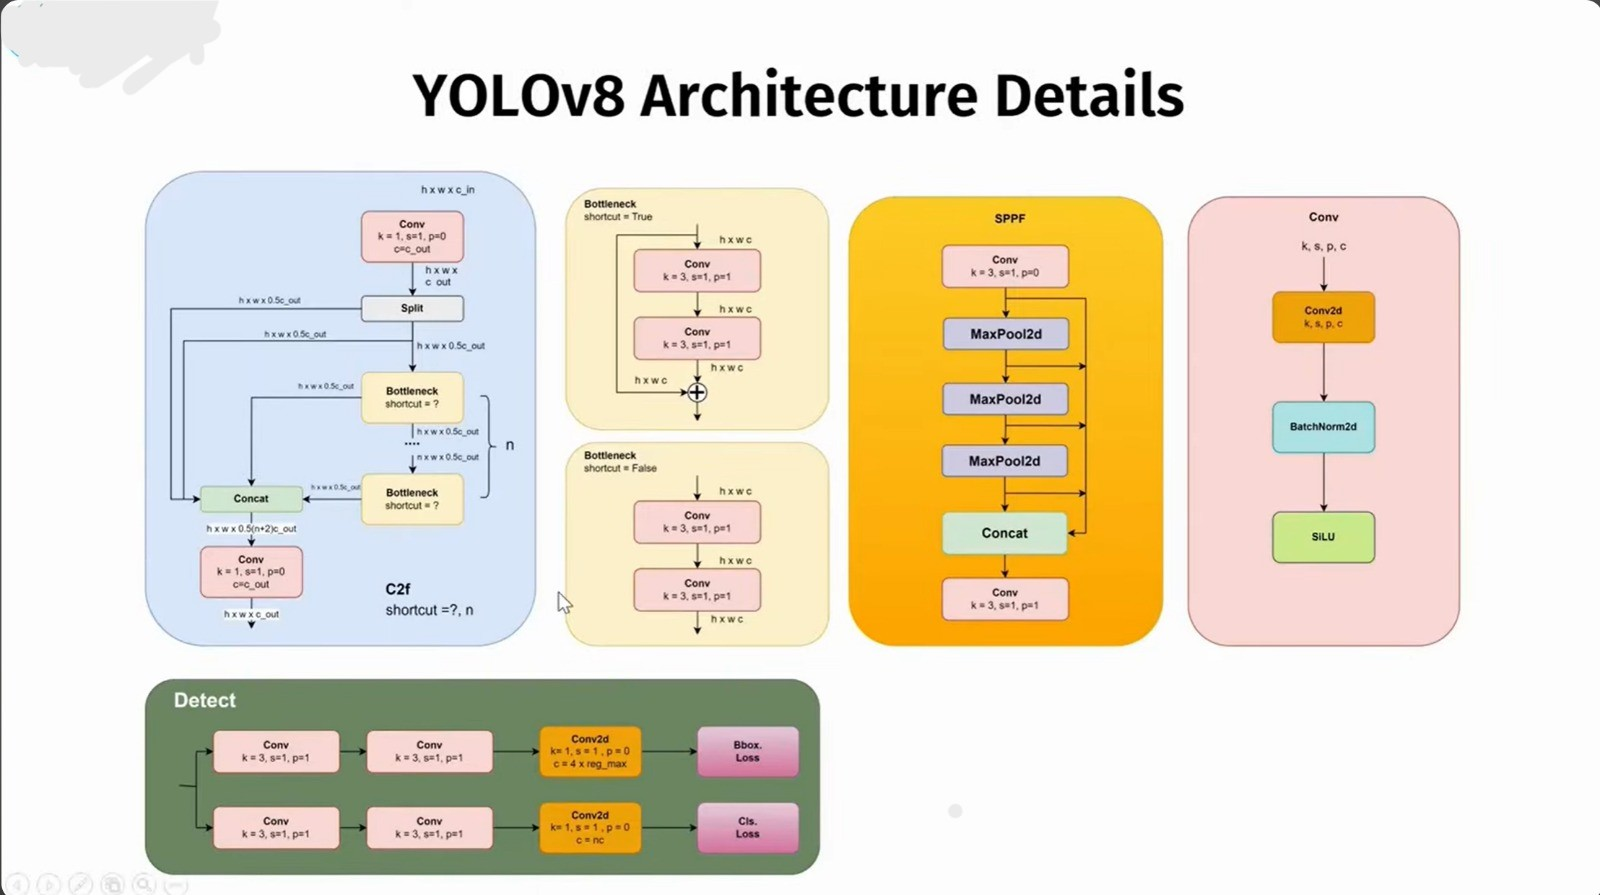

In [ ]:

mc = 1024
w = 0.25
d = 0.33


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1):
        super(ConvBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.silu(x)

        return x


class SpatialPyramidPooling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SpatialPyramidPooling, self).__init__()

        # Convolutional blocks
        self.conv_block1 = ConvBlock(in_channels, out_channels, kernel_size=3, stride=1, padding=0)
        self.conv_block2 = ConvBlock(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

        # Max pooling layers with different kernel sizes and strides
        self.maxpool1 = nn.MaxPool2d(kernel_size=1, stride=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        # Forward pass through the first convolutional block
        x1 = self.conv_block1(x)

        # Spatial pyramid pooling
        x1_pooled1 = self.maxpool1(x1)
        x1_pooled2 = self.maxpool2(x1)
        x1_pooled3 = self.maxpool3(x1)

        # Concatenate the outputs of the max pooling layers with x1
        x1_concat = torch.cat([x1, x1_pooled1, x1_pooled2, x1_pooled3], dim=1)

        # Forward pass through the second convolutional block
        x1_concat = self.conv_block2(x1_concat)

        return x1_concat


class BottleneckNeck(nn.Module):
    def __init__(self, in_channels, out_channels, shortcut=False):
        super(BottleneckNeck, self).__init__()

        # Convolutional blocks
        self.conv_block1 = ConvBlock(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv_block2 = ConvBlock(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.shortcut = shortcut

    def forward(self, x):
        # Forward pass through the bottleneck neck
        residual = x
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        if self.shortcut:
            x += residual

        return x


class CtoF(nn.Module):
    def __init__(self, in_channels, out_channels, num_bottlenecks, shortcut=True):
        super(CtoF, self).__init__()

        # Calculate the number of output channels for the first convolutional block
        out_channels_conv1 = int(min(128, mc) * w)  # Ensure it's an integer

        # Convolutional blocks
        self.conv_block1 = ConvBlock(in_channels=in_channels, out_channels=out_channels_conv1, kernel_size=1, stride=1, padding=0)
        self.conv_block2 = ConvBlock(in_channels=out_channels_conv1 * 2, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

        # Create a list to hold the BottleneckNeck modules
        self.bottlenecks = nn.ModuleList()

        # Add the specified number of BottleneckNeck modules to the list
        for _ in range(round(3 * d)):
            self.bottlenecks.append(BottleneckNeck(in_channels=out_channels_conv1, out_channels=out_channels_conv1, shortcut=shortcut))

    def forward(self, x):
        # Forward pass through the bottleneck neck
        x = self.conv_block1(x)

        # Split the channels into two halves
        channels_half = x.size(1) // 2
        x1, x2 = torch.split(x, channels_half, dim=1)
        # Concatenate the processed halves
        x = torch.cat([x1, x2], dim=1)

        # Process each half through bottleneck blocks
        for bottleneck in self.bottlenecks:
            x2 = bottleneck(x2)
            x = torch.cat([x1, x2], dim=1)

        # Apply the final convolutional block
        x = self.conv_block2(x)

        return x




class DetectionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(DetectionBlock, self).__init__()

        self.conv = ConvBlock(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

        # Classification Convolutional Layer
        self.cls_conv = nn.Conv2d(out_channels, num_classes, kernel_size=1, stride=1, padding=0)
        self.bbox_conv = nn.Conv2d(out_channels, 4, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # Forward pass for classification
        cls_x = self.conv(x)
        cls_x = self.conv(cls_x)
        cls_pred = self.cls_conv(cls_x)

        # Forward pass for bounding box prediction
        bbox_x = self.conv(x)
        bbox_x = self.conv(bbox_x)
        bbox_pred = self.bbox_conv(bbox_x)

        return cls_pred, bbox_pred


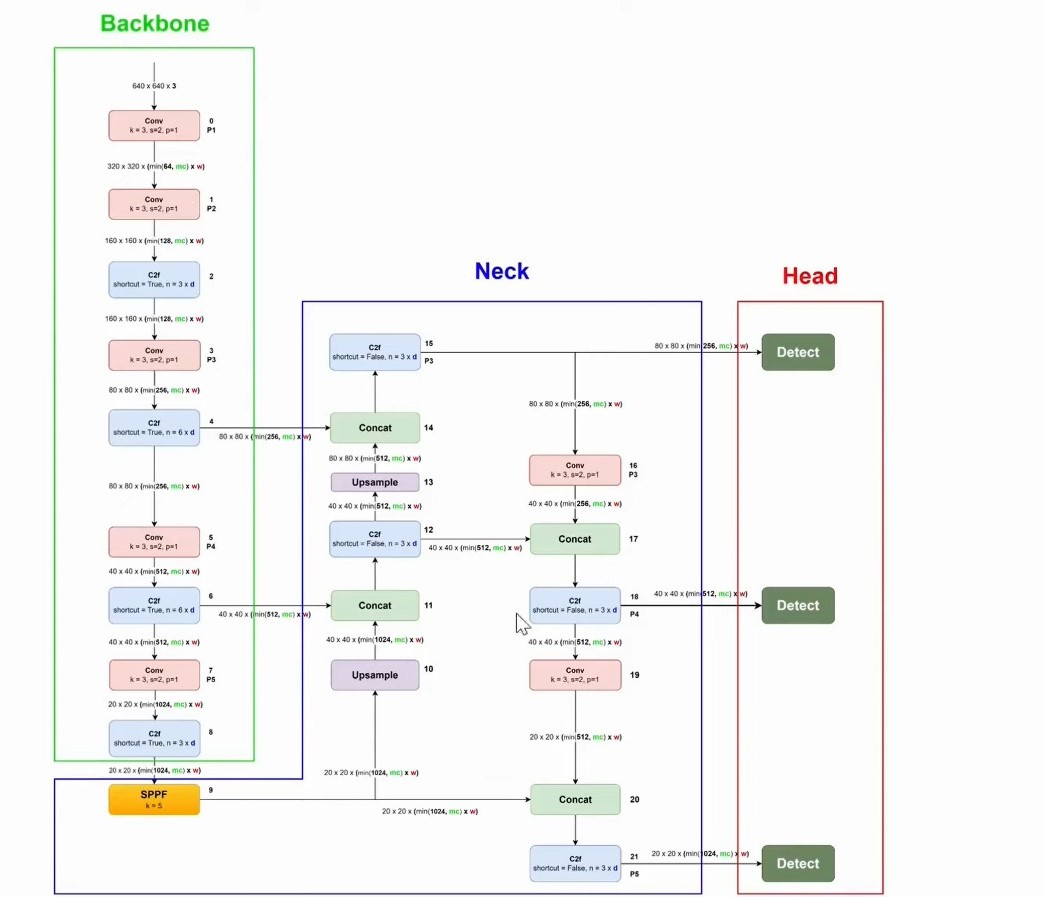

In [ ]:

class YOLO(nn.Module):
    def __init__(self, in_channels, out_channels, num_bottlenecks, shortcut=False):
        super(YOLO, self).__init__()

        # Define the convolution layer
        self.conv = ConvBlock(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.CtoF_block_false = CtoF(in_channels, out_channels, num_bottlenecks, shortcut=False)
        self.CtoF_block_true = CtoF(in_channels, out_channels, num_bottlenecks, shortcut=True)
        self.SPPf_block = SpatialPyramidPooling(in_channels, out_channels)
        self.detection_block = DetectionBlock(in_channels=in_channels, out_channels=out_channels, num_classes=10)

    def forward(self, x):
        # Forward pass through the convolution layer
        x = self.conv(x)

        # Other forward pass code...
        x = self.CtoF_block_true(x)
        x = self.conv(x)
        ctof_output_one = self.CtoF_block_true(x)
        x = self.conv(ctof_output_one)
        ctof_output_two = self.CtoF_block_true(x)
        x = self.conv(ctof_output_two)
        x = self.CtoF_block_true(x)
        sppf_output = self.SPPf_block(x)
        upsampled_x = F.interpolate(sppf_output, scale_factor=2, mode='nearest')
        x = torch.cat([upsampled_x, ctof_output_two], dim=1)
        ctof_output_three = self.CtoF_block_false(x)
        upsampled_x = F.interpolate(ctof_output_three, scale_factor=2, mode='nearest')
        x = torch.cat([upsampled_x, ctof_output_one], dim=1)
        ctof_output_four = self.CtoF_block_false(x)
        x = self.conv(ctof_output_four)
        x = torch.cat([x, ctof_output_three], dim=1)
        ctof_output_five = self.CtoF_block_false(x)
        x = self.conv(ctof_output_five)
        x = torch.cat([x, sppf_output], dim=1)
        ctof_output_six = self.CtoF_block_true(x)

        detect1 = self.detection_block(ctof_output_four)
        detect2 = self.detection_block(ctof_output_five)
        detect3 = self.detection_block(ctof_output_six)

        return detect1, detect2, detect3



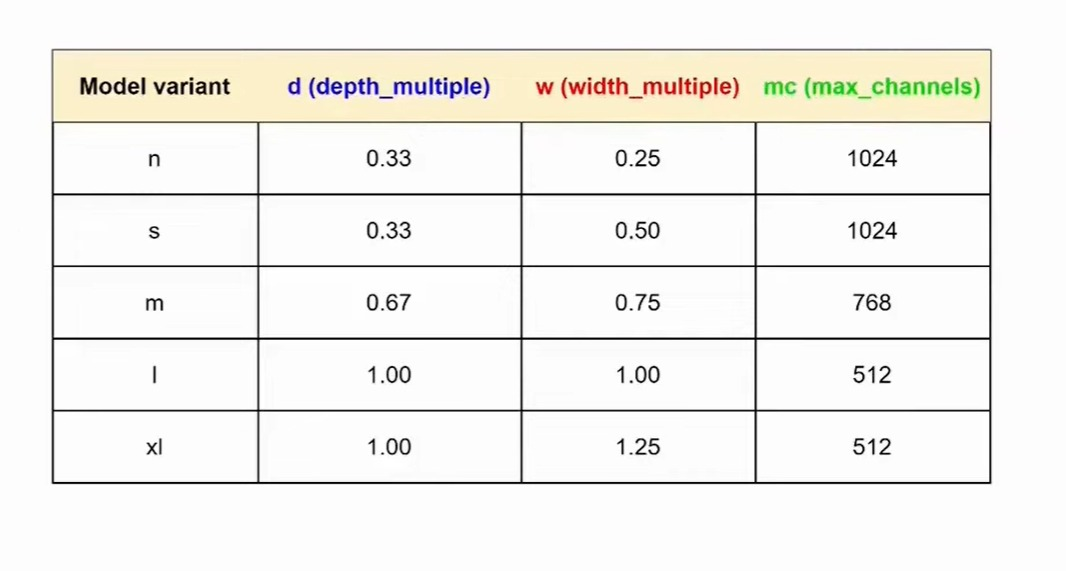

In [ ]:
boxes = []
for i, (cls_pred, bbox_pred) in enumerate(results):
  boxes.append((cls_pred, bbox_pred))
i = 0,j = 1
while i <=len(boxes)-2:
  (x1_tl, y1_tl, x1_br, y1_br) = boxes[i][1]
  while i<j<=len(boxes)-1:
    (x2_tl, y2_tl, x2_br, y2_br) = boxes[j][1]
    box1 = (x1_tl, y1_tl, x1_br, y1_br)
    box2 = (x2_tl, y2_tl, x2_br, y2_br)
    iou = calculate_iou(box1, box2)
    if iou>0.5:
      boxes.pop(j)
    else:
      j+=1
  i+=1


In [ ]:
boxes = []
for i, (cls_pred, bbox_pred) in enumerate(results):
    boxes.append((cls_pred, bbox_pred))

In [ ]:
def calculate_iou(box1, box2):
    # Extract coordinates of boxes
    x1_tl, y1_tl, x1_br, y1_br = box1
    x2_tl, y2_tl, x2_br, y2_br = box2

    # Calculate intersection coordinates
    x_tl = max(x1_tl, x2_tl)
    y_tl = max(y1_tl, y2_tl)
    x_br = min(x1_br, x2_br)
    y_br = min(y1_br, y2_br)

    # Calculate intersection area
    intersection_area = max(0, x_br - x_tl + 1) * max(0, y_br - y_tl + 1)

    # Calculate areas of both boxes
    box1_area = (x1_br - x1_tl + 1) * (y1_br - y1_tl + 1)
    box2_area = (x2_br - x2_tl + 1) * (y2_br - y2_tl + 1)

    # Calculate Union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou


def non_max_suppression(boxes, threshold=0.5):

    # Sort the boxes by confidence score (highest first)
    boxes.sort(key=lambda x: x[0], reverse=True)

    # Initialize list to store suppressed boxes
    suppressed_boxes = []

    # Iterate through each box
    while len(boxes) > 0:
        # Select the box with highest confidence (top box)
        top_box = boxes.pop(0)
        suppressed_boxes.append(top_box)

        # Iterate through remaining boxes and remove those with high IoU
        remaining_boxes = []
        for box in boxes:
            iou = calculate_iou(top_box[1], box[1])
            if iou < threshold:
                remaining_boxes.append(box)

        # Update the list of remaining boxes
        boxes = remaining_boxes

    return suppressed_boxes


In [ ]:
cls_loss_function = nn.CrossEntropyLoss()
bbox_loss_function = nn.SmoothL1Loss()

cls_losses = []
bbox_losses = []

for cls_pred, bbox_pred in suppressed_boxes:
    # Calculate classification loss
    cls_gt = ...  # Ground truth class labels
    cls_loss = cls_loss_function(cls_pred, cls_gt)
    cls_losses.append(cls_loss.item())

    # Calculate bounding box regression loss
    bbox_gt = ...  # Ground truth bounding box coordinates
    bbox_loss = bbox_loss_function(bbox_pred, bbox_gt)
    bbox_losses.append(bbox_loss.item())

# Aggregate losses
total_cls_loss = sum(cls_losses) / len(cls_losses)
total_bbox_loss = sum(bbox_losses) / len(bbox_losses)

# Total loss
total_loss = total_cls_loss + total_bbox_loss


In [ ]:
import torch.optim as optim

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_idx, (images, targets) in enumerate(train_loader):
        # Forward pass
        cls_pred, bbox_pred = model(images)

        # Calculate classification and bbox regression losses
        cls_loss = cls_loss_function(cls_pred, targets['cls_labels'])
        bbox_loss = bbox_loss_function(bbox_pred, targets['bbox_coords'])

        # Total loss
        loss = cls_loss + bbox_loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update total loss
        total_loss += loss.item()

        # Print progress
        if (batch_idx + 1) % log_interval == 0:
            avg_loss = total_loss / log_interval
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {avg_loss:.4f}')
            total_loss = 0.0

# Save the trained model
torch.save(model.state_dict(), 'yolo_model.pth')


In [ ]:
import torch

# Example input tensor
batch_size = 1
in_channels = 256
height = 4
width = 4
num_classes = 10
input_tensor = torch.randn(batch_size, in_channels, height, width)

# Instantiate DetectionBlock
detection_block = DetectionBlock(in_channels=in_channels, out_channels=128, num_classes=num_classes)

# Pass input through DetectionBlock
cls_pred, bbox_pred = detection_block(input_tensor)

# Print the shapes of output tensors
print("Class Prediction Shape:", cls_pred.shape)  # Shape should be (batch_size, num_classes, height, width)
print("Bounding Box Prediction Shape:", bbox_pred.shape)  # Shape should be (batch_size, 4, height, width) assuming 4 parameters for bounding box
print("Bounding Box Prediction :", bbox_pred)


Class Prediction Shape: torch.Size([1, 10, 4, 4])
Bounding Box Prediction Shape: torch.Size([1, 4, 4, 4])
Bounding Box Prediction : tensor([[[[ 0.0621, -0.6048, -0.1010,  0.0139],
          [-0.2237,  0.1698, -0.7060, -1.3081],
          [-0.4592, -1.0911,  0.1555, -0.3677],
          [-0.1951, -0.5965, -0.0266, -0.3736]],

         [[-0.2432, -0.0611, -0.2180,  0.2229],
          [-0.0408, -0.0813,  0.1339,  0.6817],
          [ 0.1962,  0.1286, -0.4943, -0.6037],
          [ 0.3752,  0.2048, -0.2983, -0.2534]],

         [[-0.2729,  0.1671,  0.2818,  0.3814],
          [-0.0888, -0.0835,  0.0830, -0.4513],
          [-0.0469,  0.5426,  1.0829, -0.0909],
          [ 0.0577, -0.0228, -0.4651, -0.4176]],

         [[-0.7995,  0.4421, -0.8342,  0.0062],
          [-0.7235,  0.4151,  0.0535,  0.4104],
          [ 0.2235,  0.0946,  0.8800,  0.3884],
          [-0.6048,  0.2270, -0.0436,  0.3994]]]],
       grad_fn=<ConvolutionBackward0>)


In [ ]:
import torch

def to_xywh_format(bbox_pred):
    # Assuming bbox_pred is obtained from the DetectionBlock

    # Get the dimensions of the bounding box prediction tensor
    batch_size, _, height, width = bbox_pred.shape

    # Generating grid coordinates for each sample in the batch
    y_indices, x_indices = torch.meshgrid(torch.arange(height), torch.arange(width))
    y_indices = y_indices.float().to(bbox_pred.device)
    x_indices = x_indices.float().to(bbox_pred.device)

    # Expand dimensions to match the batch size
    x_indices = x_indices.unsqueeze(0).unsqueeze(0).expand(batch_size, -1, -1, -1)
    y_indices = y_indices.unsqueeze(0).unsqueeze(0).expand(batch_size, -1, -1, -1)

    # Calculate x and y coordinates (center of bounding box)
    x_center = (torch.sigmoid(bbox_pred[:, :, :, 0].unsqueeze(1)) + x_indices) / width
    y_center = (torch.sigmoid(bbox_pred[:, :, :, 1].unsqueeze(1)) + y_indices) / height

    # Calculate width and height of bounding box
    w = torch.exp(bbox_pred[:, :, :, 2].unsqueeze(1))
    h = torch.exp(bbox_pred[:, :, :, 3].unsqueeze(1))

    # Return bounding box predictions in (x, y, w, h) format
    return [x_center, y_center, w, h]

# Example bounding box predictions tensor
bbox_pred = torch.tensor([[[[ 0.0621, -0.6048, -0.1010, 0.0139],
                            [-0.2237, 0.1698, -0.7060, -1.3081],
                            [-0.4592, -1.0911, 0.1555, -0.3677],
                            [-0.1951, -0.5965, -0.0266, -0.3736]]]])

# Convert bounding box predictions to (x, y, w, h) format
bbox_xywh = to_xywh_format(bbox_pred)

print("Bounding Box Predictions (x, y, w, h):", bbox_xywh)


Bounding Box Predictions (x, y, w, h): [tensor([[[[0.1289, 0.3611, 0.5968, 0.8628],
          [0.1289, 0.3611, 0.5968, 0.8628],
          [0.1289, 0.3611, 0.5968, 0.8628],
          [0.1289, 0.3611, 0.5968, 0.8628]]]]), tensor([[[[0.0883, 0.1356, 0.0629, 0.0888],
          [0.3383, 0.3856, 0.3129, 0.3388],
          [0.5883, 0.6356, 0.5629, 0.5888],
          [0.8383, 0.8856, 0.8129, 0.8388]]]]), tensor([[[[0.9039, 0.4936, 1.1682, 0.9738]]]]), tensor([[[[1.0140, 0.2703, 0.6923, 0.6883]]]])]


In [ ]:
import torch.nn as nn

class DetectionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(DetectionBlock, self).__init__()

        # Classification Convolutional Blocks
        self.cls_conv_block1 = ConvBlock(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.cls_conv_block2 = ConvBlock(out_channels, out_channels // 2, kernel_size=3, stride=1, padding=1)
        self.cls_conv = nn.Conv2d(out_channels // 2, num_classes, kernel_size=1, stride=1, padding=0)

        # Bounding Box Convolutional Blocks
        self.bbox_conv_block1 = ConvBlock(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bbox_conv_block2 = ConvBlock(out_channels, out_channels // 2, kernel_size=3, stride=1, padding=1)
        self.bbox_conv = nn.Conv2d(out_channels // 2, 4, kernel_size=1, stride=1, padding=0)  # Assuming 4 parameters for bounding box prediction

        # Loss Functions
        self.cls_loss = nn.CrossEntropyLoss()
        self.bbox_loss = BBoxLoss()

    def forward(self, x):
        # Forward pass for classification
        cls_x = self.cls_conv_block1(x)
        cls_x = self.cls_conv_block2(cls_x)
        cls_pred = self.cls_conv(cls_x)

        # Forward pass for bounding box prediction
        bbox_x = self.bbox_conv_block1(x)
        bbox_x = self.bbox_conv_block2(bbox_x)
        bbox_pred = self.bbox_conv(bbox_x)

        return cls_pred, bbox_pred


In [ ]:
import torch

# Assuming bbox_pred contains the raw bounding box predictions from the model
# Bounding Box Prediction: tensor([[[[x1, y1, w1, h1], [x2, y2, w2, h2], ...]]])
bbox_pred = torch.tensor([[[[0.6, 0.4, 0.1, 0.2], [0.3, 0.7, 0.15, 0.25]]]])

# Apply sigmoid activation to get values between 0 and 1
bbox_pred_sigmoid = torch.sigmoid(bbox_pred)

# Scale coordinates to image dimensions
image_width = 640
image_height = 480
scaled_bbox_pred = bbox_pred_sigmoid * torch.tensor([image_width, image_height, image_width, image_height])

# Extract x, y, w, h from the scaled predictions
x = scaled_bbox_pred[:, :, :, 0]
y = scaled_bbox_pred[:, :, :, 1]
w = scaled_bbox_pred[:, :, :, 2]
h = scaled_bbox_pred[:, :, :, 3]

print("x:", x)
print("y:", y)
print("w:", w)
print("h:", h)


x: tensor([[[413.2200, 367.6432]]])
y: tensor([[[287.3701, 320.7301]]])
w: tensor([[[335.9867, 343.9551]]])
h: tensor([[[263.9203, 269.8447]]])


In [ ]:
import torch.nn.functional as F

def bbox_loss(pred_bbox, target_bbox):
    # Extracting predicted bounding box coordinates
    pred_x, pred_y,  = pred_bbox.unbind(-1)

    # Extracting ground truth bounding box coordinates
    target_x, target_y, = target_bbox.unbind(-1)

    # Compute smooth L1 loss or MSE loss for each bounding box coordinate
    loss_x = F.smooth_l1_loss(pred_x, target_x, reduction='sum')
    loss_y = F.smooth_l1_loss(pred_y, target_y, reduction='sum')

    # Summing up the losses for all bounding box coordinates
    total_loss = loss_x + loss_y

    return total_loss

# Example usage
pred_bbox = torch.tensor([[[413.2200, 367.6432]]])
target_bbox = torch.tensor([[[287.3701, 320.7301]]])

loss = bbox_loss(pred_bbox, target_bbox)
print("Bounding Box Loss:", loss.item())


Bounding Box Loss: 171.76300048828125


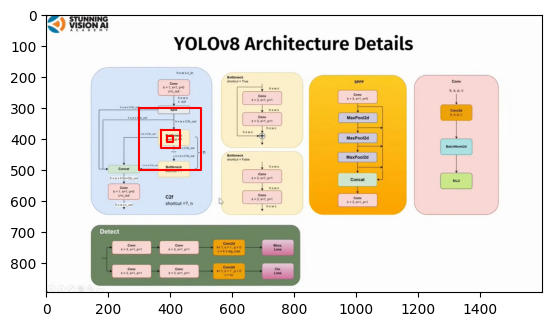

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample bounding box predictions at different scales
# Adjust these values according to your actual predictions
bbox_predictions_scale1 = np.array([[100, 100, 50, 50]])  # Example bounding box prediction at scale 1
bbox_predictions_scale2 = np.array([[200, 200, 30, 30]])  # Example bounding box prediction at scale 2
bbox_predictions_scale3 = np.array([[400, 400, 20, 20]])  # Example bounding box prediction at scale 3

# Scale factors for each detection block (example values)
scale_factor_scale1 = 4
scale_factor_scale2 = 2
scale_factor_scale3 = 1

# Adjust bounding box predictions to original image scale
bbox_predictions_scale1[:, :2] *= scale_factor_scale1
bbox_predictions_scale1[:, 2:] *= scale_factor_scale1

bbox_predictions_scale2[:, :2] *= scale_factor_scale2
bbox_predictions_scale2[:, 2:] *= scale_factor_scale2

bbox_predictions_scale3[:, :2] *= scale_factor_scale3
bbox_predictions_scale3[:, 2:] *= scale_factor_scale3

# Load and display the original image
# Replace 'image_path' with the path to your input image
image = plt.imread("/content/image.jpeg")
plt.imshow(image)

# Plot bounding boxes detected at different scales
for bbox in [bbox_predictions_scale1, bbox_predictions_scale2, bbox_predictions_scale3]:
    x, y, w, h = bbox[0]
    xmin = x - w / 2
    ymin = y - h / 2
    xmax = x + w / 2
    ymax = y + h / 2
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color='red')

plt.show()
